In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import random
import os
import shutil
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.client import device_lib
from collections import defaultdict
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4099009538104636010
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2254123828
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4633122054402639966
 physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [9]:

def count_pictures_in_classes(folder_path):
    class_counts = defaultdict(int)

    for root, dirs, files in os.walk(folder_path):
        for file in files:
                 class_name = os.path.basename(root)
                 class_counts[class_name] += 1

    return dict(class_counts)



def plot_class_counts(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(20,10))

    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class Name')
    plt.ylabel('Number of Pictures')
    plt.title('Picture Counts in Each Class')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()



Class Counts: {'Apple___Apple_scab': 2016, 'Apple___Black_rot': 1987, 'Apple___Cedar_apple_rust': 1760, 'Apple___healthy': 2008, 'Cherry_(including_sour)___healthy': 1826, 'Cherry_(including_sour)___Powdery_mildew': 1683, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642, 'Corn_(maize)___Common_rust_': 1907, 'Corn_(maize)___healthy': 1859, 'Corn_(maize)___Northern_Leaf_Blight': 1908, 'cotton__Aphids': 480, 'cotton__Army worm': 480, 'cotton__Bacterial Blight': 480, 'cotton__Healthy': 480, 'cotton__Powdery Mildew': 480, 'cotton__Target spot': 481, 'Grape___Black_rot': 1888, 'Grape___Esca_(Black_Measles)': 1920, 'Grape___healthy': 1692, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1722, 'Orange___Haunglongbing_(Citrus_greening)': 2010, 'Peach___Bacterial_spot': 1838, 'Peach___healthy': 1728, 'Pepper,_bell___Bacterial_spot': 1913, 'Pepper,_bell___healthy': 1988, 'Potato___Early_blight': 1939, 'Potato___healthy': 1824, 'Potato___Late_blight': 1939, 'Squash___Powdery_mildew': 1736,

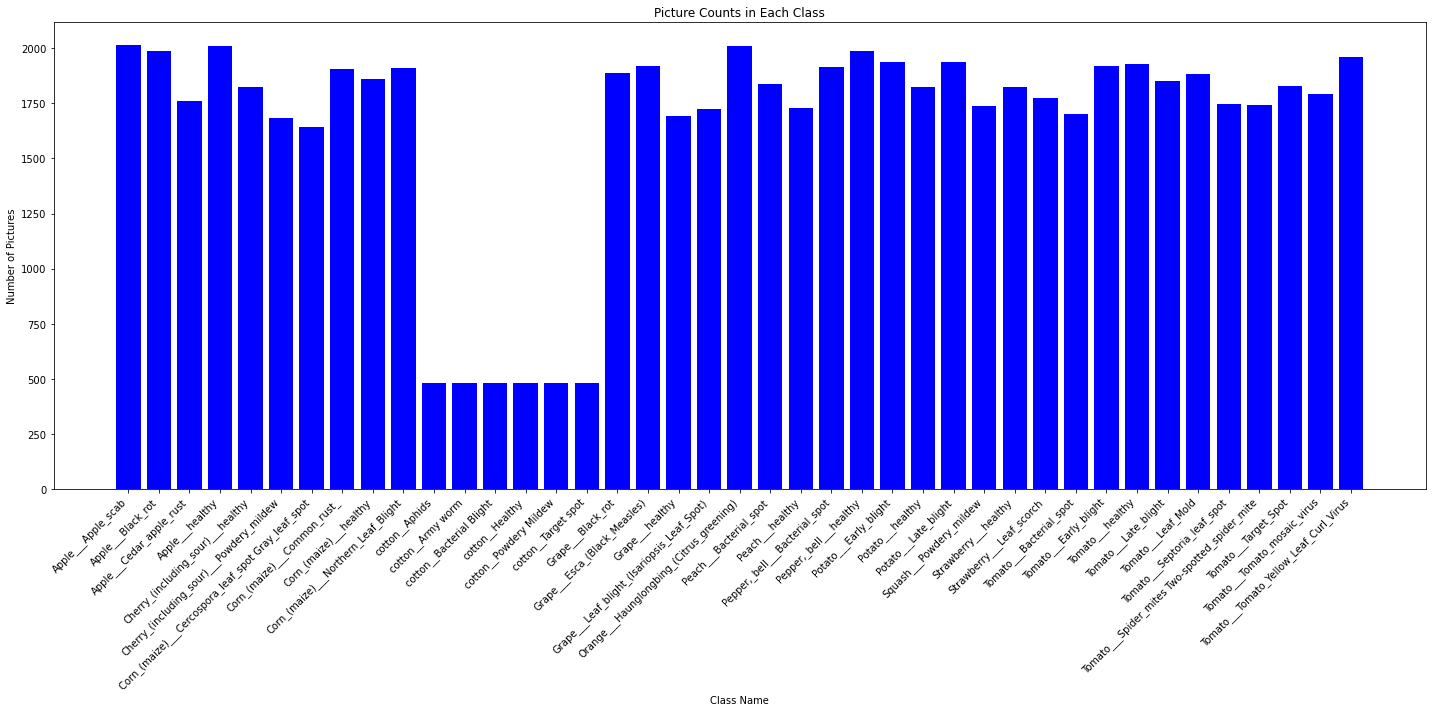

In [10]:
folder_path = r"E:\Users\ahmed\OneDrive\Desktop\modelv2\train"
class_counts = count_pictures_in_classes(folder_path)
print("Class Counts:", class_counts)
plot_class_counts(class_counts)

Class Counts: {'Apple___Apple_scab': 504, 'Apple___Black_rot': 497, 'Apple___Cedar_apple_rust': 440, 'Apple___healthy': 502, 'Cherry_(including_sour)___healthy': 456, 'Cherry_(including_sour)___Powdery_mildew': 421, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 410, 'Corn_(maize)___Common_rust_': 477, 'Corn_(maize)___healthy': 465, 'Corn_(maize)___Northern_Leaf_Blight': 477, 'cotton__Aphids': 120, 'cotton__Army worm': 120, 'cotton__Bacterial Blight': 120, 'cotton__Healthy': 120, 'cotton__Powdery Mildew': 120, 'cotton__Target spot': 120, 'Grape___Black_rot': 472, 'Grape___Esca_(Black_Measles)': 480, 'Grape___healthy': 423, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 430, 'Orange___Haunglongbing_(Citrus_greening)': 503, 'Peach___Bacterial_spot': 459, 'Peach___healthy': 432, 'Pepper,_bell___Bacterial_spot': 478, 'Pepper,_bell___healthy': 497, 'Potato___Early_blight': 485, 'Potato___healthy': 456, 'Potato___Late_blight': 485, 'Squash___Powdery_mildew': 434, 'Strawberry___healthy'

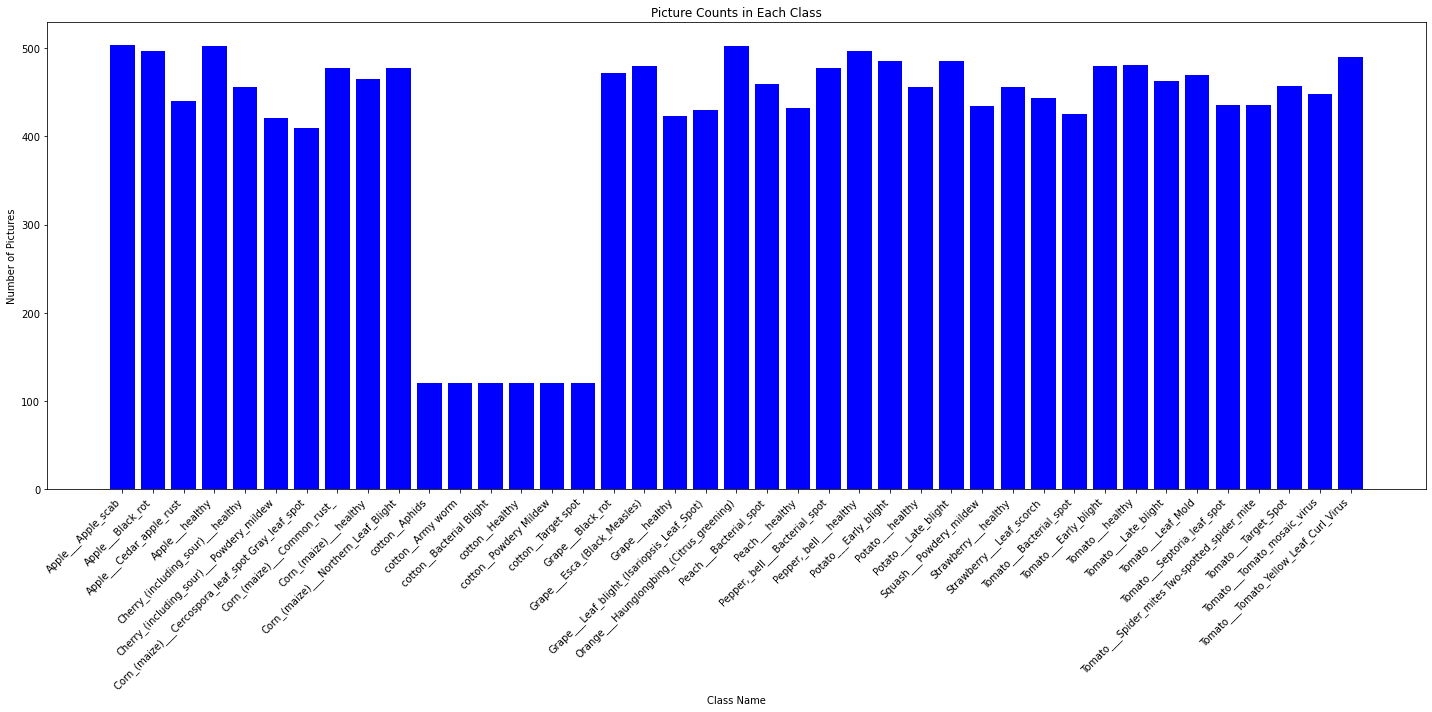

In [11]:
folder_path = r"E:\Users\ahmed\OneDrive\Desktop\modelv2\valid"
class_counts = count_pictures_in_classes(folder_path)
print("Class Counts:", class_counts)
plot_class_counts(class_counts)

In [18]:
imsize=256
batch=32
chanels=3
epoch=20
n_classes=41


In [19]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\Users\ahmed\OneDrive\Desktop\modelv2\train",
    shuffle=True,
    image_size=(imsize, imsize),
    batch_size=batch,
)



Found 67557 files belonging to 41 classes.


In [20]:
validation_data=tf.keras.preprocessing.image_dataset_from_directory(
     r"E:\Users\ahmed\OneDrive\Desktop\modelv2\valid",
    shuffle=True,
    image_size=(imsize,imsize),
    batch_size=batch,
    

    )

 

Found 16888 files belonging to 41 classes.


In [21]:
 def split_data(ds,val_split=0.50,test_split=0.50,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size,seed=5)
        
    val_size=int(val_split*ds_size)
    
    val_ds=ds.take(val_size)
    test_ds=ds.skip(val_size)
    
    
    return val_ds,test_ds
    
    
    
    
    

In [22]:
val_ds,test_ds= split_data(validation_data)


In [45]:
class_name=train_data.class_names
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_C

In [24]:
for im_batch,lebal in train_data.take(1):
    print(im_batch.shape)
    print(lebal.numpy())

(32, 256, 256, 3)
[26 14 26  0 22 15  8  1 21 25 13 21 14 38  7 14 18 18 28 26  8  3 23 29
 27 14 23 12 24 14 12  4]


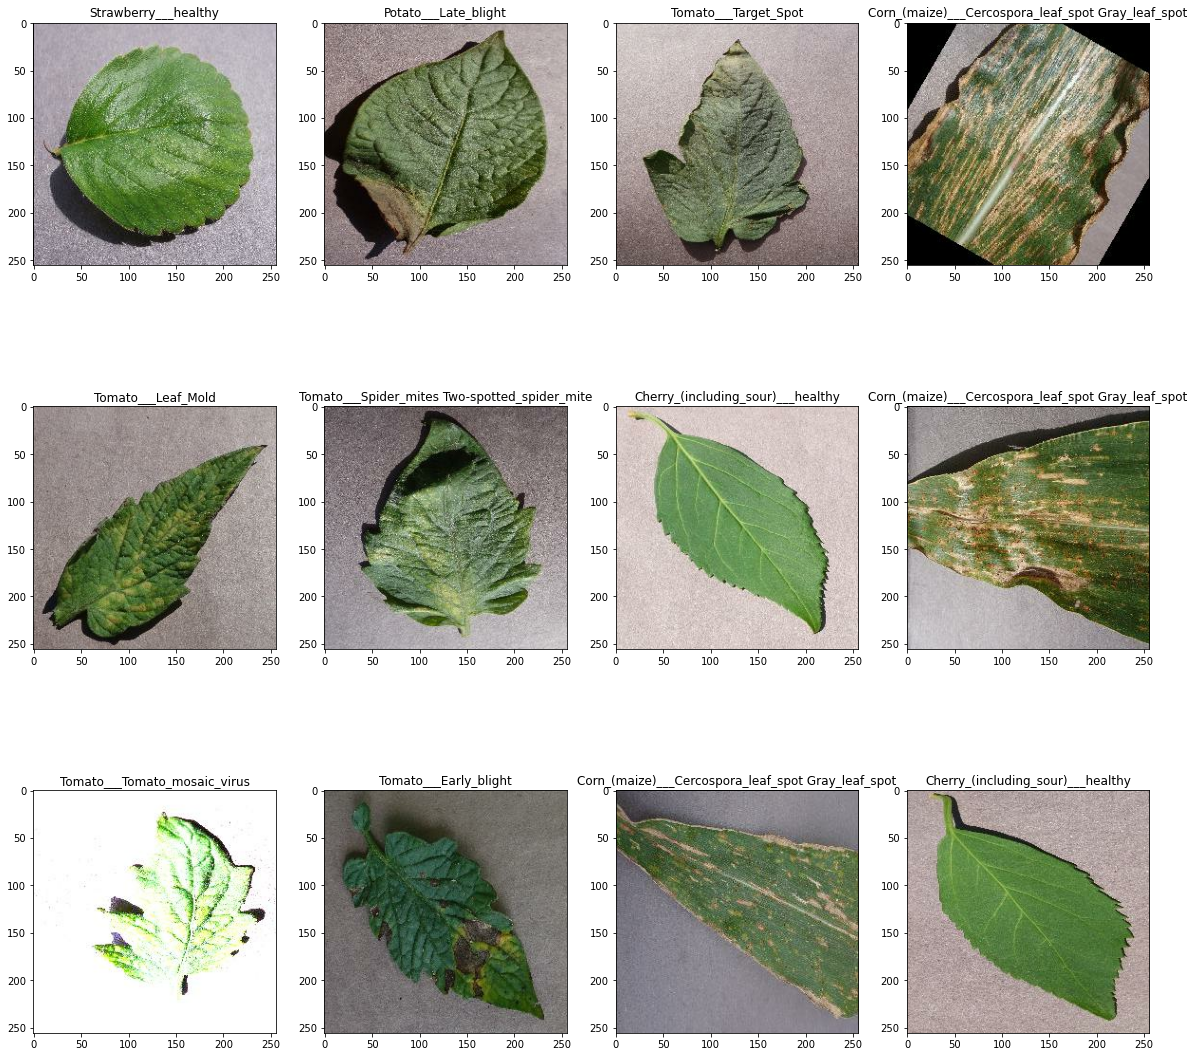

In [25]:
plt.figure(figsize=(20,20))
for im_batch,lebal in train_data.take(1):
    for i in  range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_name[lebal[i]])
        plt.imshow(im_batch[i].numpy().astype("uint8"))

In [26]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imsize,imsize),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
    
])

In [27]:
input_shape=(batch,imsize,imsize,chanels)
model=models.Sequential ([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(n_classes,activation='softmax'),


])

In [28]:
model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [30]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]


)

In [31]:

early_stopping_cb = EarlyStopping(monitor="val_loss",patience=3)
 

In [32]:
history=model.fit(
    train_data,
    epochs=epoch,
    batch_size=batch,
    verbose=1,
    validation_data=val_ds,
#     callbacks=[early_stopping_cb]    



)




Epoch 1/20
2112/2112 [==============================] - 245s 113ms/step - loss: 1.4780 - accuracy: 0.5624 - val_loss: 0.7158 - val_accuracy: 0.7719
Epoch 2/20
2112/2112 [==============================] - 252s 119ms/step - loss: 0.4826 - accuracy: 0.8445 - val_loss: 0.4223 - val_accuracy: 0.8662
Epoch 3/20
2112/2112 [==============================] - 246s 116ms/step - loss: 0.3156 - accuracy: 0.8979 - val_loss: 0.3747 - val_accuracy: 0.8804
Epoch 4/20
2112/2112 [==============================] - 233s 110ms/step - loss: 0.2417 - accuracy: 0.9194 - val_loss: 0.2417 - val_accuracy: 0.9226
Epoch 5/20
2112/2112 [==============================] - 232s 110ms/step - loss: 0.1881 - accuracy: 0.9381 - val_loss: 0.2319 - val_accuracy: 0.9308
Epoch 6/20
2112/2112 [==============================] - 231s 109ms/step - loss: 0.1638 - accuracy: 0.9452 - val_loss: 0.2622 - val_accuracy: 0.9195
Epoch 7/20
2112/2112 [==============================] - 229s 109ms/step - loss: 0.1438 - accuracy: 0.9523 - val_

In [34]:
score=model.evaluate(test_ds)

264/264 [==============================] - 13s 39ms/step - loss: 0.2045 - accuracy: 0.9492


In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

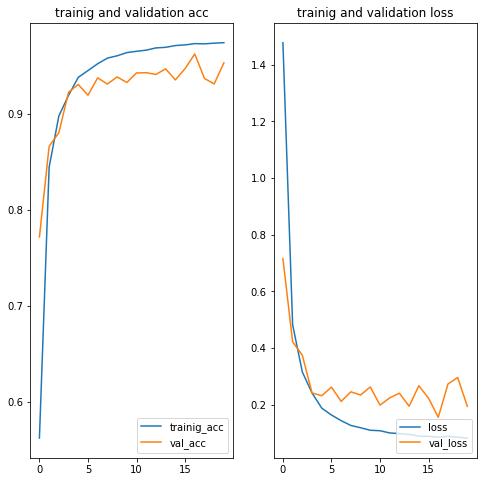

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label="trainig_acc")
plt.plot(range(20),val_acc,label="val_acc")
plt.legend(loc="lower right")
plt.title("trainig and validation acc")

plt.subplot(1,2,2)
plt.plot(range(20),loss,label="loss")
plt.plot(range(20),val_loss,label="val_loss")
plt.legend(loc="lower right")
plt.title("trainig and validation loss")


plt.show()

actul_label:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
1/1 [==============================] - 0s 26ms/step
predicted:  Tomato___Tomato_Yellow_Leaf_Curl_Virus


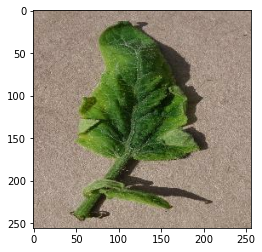

In [40]:
for im_batch,lebal in test_ds.take(1):
  first_im=im_batch[0].numpy().astype("uint8")
  first_label=lebal[0].numpy()
  plt.imshow(first_im)

  print("actul_label: ",class_name[first_label])
  prediction=model.predict(im_batch)
  print("predicted: ",class_name[np.argmax(prediction[0])])


In [41]:
 def predict(model,img):
   img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
   img_array=tf.expand_dims(img_array,0)

   prediction=model.predict(img_array)
   predicted_class=class_name[np.argmax(prediction[0])]
   confidence=round(100*(np.max(prediction[0])),2)
   return predicted_class,confidence


1/1 [==============================] - 0s 17ms/step


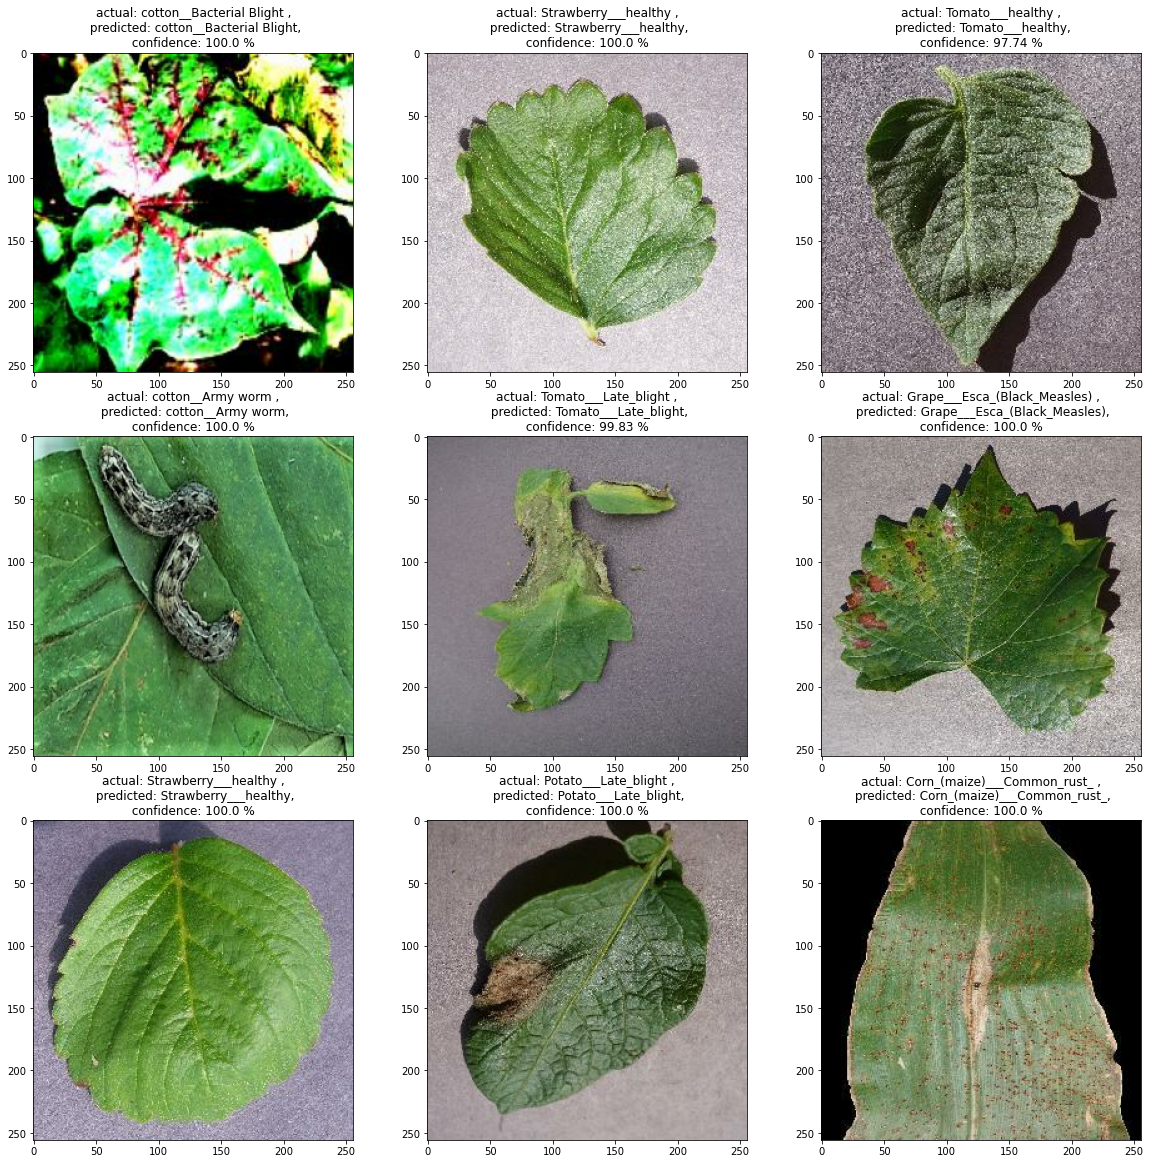

In [46]:
plt.figure(figsize=(20,20))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_name[labels[i]]
    plt.title(f"actual: {actual_class} ,\n predicted: {predicted_class},\n confidence: {confidence} % ")

In [47]:
labels = []
predictions = []
for x,y in test_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 24ms/step


In [48]:
import itertools

predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [49]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 97.42 %
Test Accuracy   : 94.89 %
Precision Score : 94.89 %
Recall Score    : 94.89 %


<Figure size 1440x360 with 0 Axes>

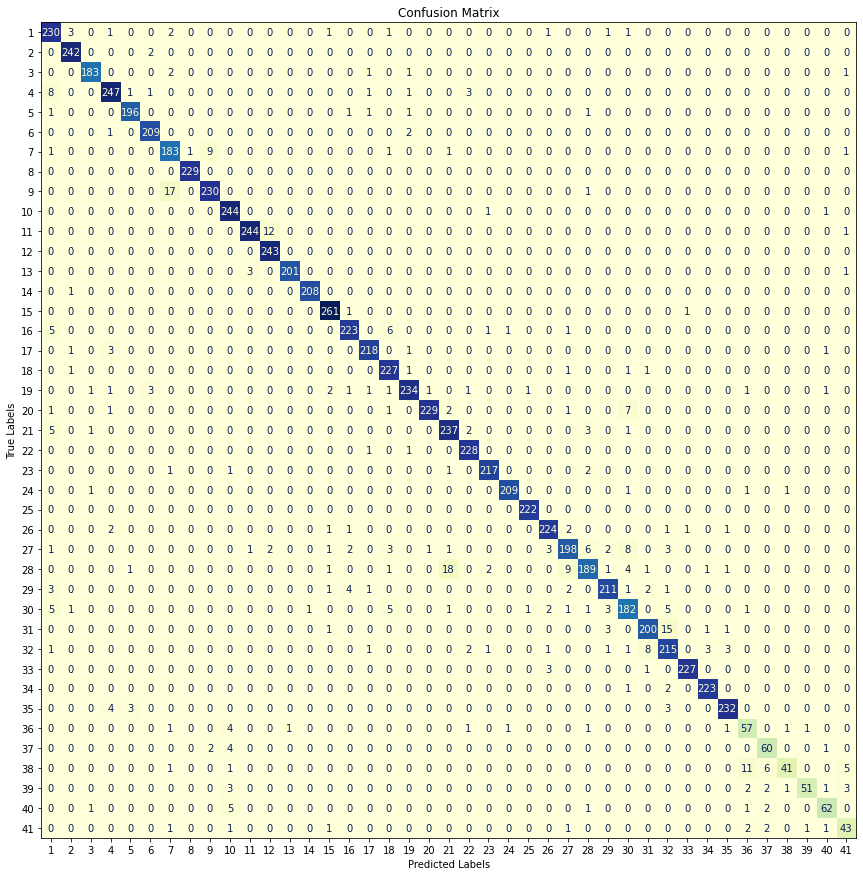

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,42)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show() 

In [52]:
from sklearn.metrics import classification_report

class_name=np.array(train_data.class_names)
class_name
print(classification_report(labels, predictions, target_names=class_name))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.88      0.95      0.92       241
                                 Apple___Black_rot       0.97      0.99      0.98       244
                          Apple___Cedar_apple_rust       0.98      0.97      0.98       188
                                   Apple___healthy       0.95      0.94      0.95       262
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98       201
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98       212
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.93      0.90       197
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       229
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.93      0.94       248
                            Corn_(maize)___healthy       0.93      0.99      0.

In [53]:
from keras.models import load_model

# Assuming 'model' is your trained model
model.save(r'E:\Users\ahmed\OneDrive\Desktop\modelv2/plant_model_v2.h5')